## OC-CCI temporal timeseries analysis for Monthly Chla in CSV format

In [1]:
%matplotlib inline
# Plot
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.dates import DateFormatter, YearLocator

# Data 
import netCDF4 as nc
import numpy as np
import pandas as pd

# Stats
import pymannkendall as mk
from scipy.stats import linregress

# Supress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
pwd

'C:\\Users\\mkmrt\\OneDrive\\Documents\\year_3'

In [3]:
#locate to data
OC = pd.read_csv("C:\\Users\\mkmrt\\OneDrive\\Documents\\year__3\\10year\\chlor_a.csv")
OC.head(3)

,date,min,max,mean,std,median
0,2013-01-01T00:00:00,4.953001,7.217649,5.960289,0.046987,5.815199
1,2013-02-01T00:00:00,4.571826,6.651100,5.937653,0.038547,6.044992
2,2013-03-01T00:00:00,3.068328,7.335114,5.291007,0.079085,5.368389


In [4]:
# Make a subset dataframe of the date and mean CHL for further processing
df = pd.DataFrame({'Date':OC['date'], 'Chl':OC['mean']})
# Make date format more friendly to use
df['Date']= pd.to_datetime(df['Date'], format=('%Y-%m-%dT%H:%M:%S'))
df.head(4)

,Date,Chl
0,2013-01-01,5.960289
1,2013-02-01,5.937653
2,2013-03-01,5.291007
3,2013-04-01,4.213456


In [5]:
# How many years in our timeseries:
num = df['Date'].dt.year.nunique()
num


11

In [6]:
# Filter the DataFrame for dates between 2013 and 2023
df_filtered = df[(df['Date'] >= '2013-01-01') & (df['Date'] <= '2023-01-01')]

In [7]:
# Extract Year and Month
df_filtered['Year'] = df_filtered['Date'].dt.year
df_filtered['Month']= df_filtered['Date'].dt.month
# Display the first few rows to verify
print(df_filtered.head(3))

        Date       Chl  Year  Month
0 2013-01-01  5.960289  2013      1
1 2013-02-01  5.937653  2013      2
2 2013-03-01  5.291007  2013      3


In [8]:
df_filtered_all = df_filtered.copy()
# Identify the midpoint index
mid_index= len(df_filtered_all) // 2
# Get the midpoint year
mid_year = df_filtered_all.iloc[mid_index]['Year']
mid_year

2018

In [9]:
# Define month names
months = [
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'June',
    'July', 'Aug', 'Sept', 'Oct', 'Nov','Dec']

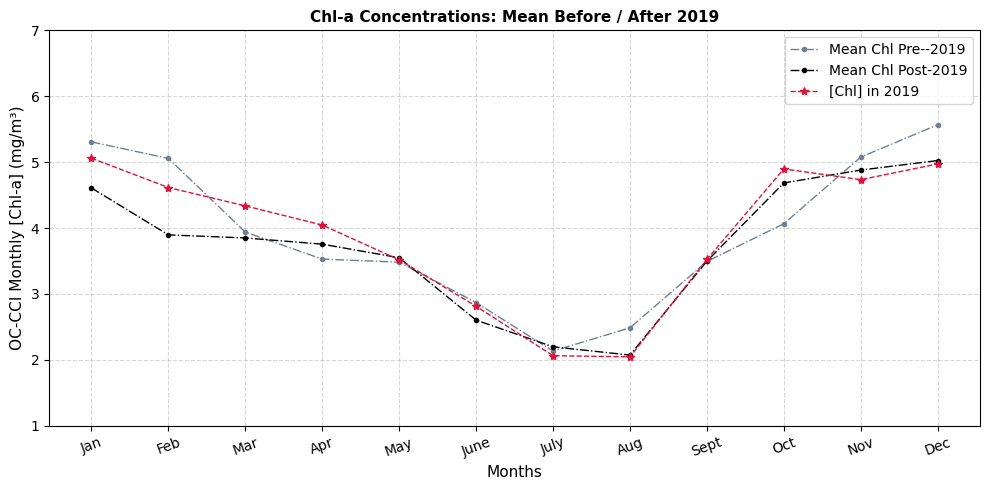

In [10]:
#"Seasonal Chl-a Variability Over Time"
#"Temporal Comparison Plot of Monthly Chlorophyll-a (Chl-a) Data"

# Split data half, keep years of interest
df_filtered_at2019 = df_filtered_all[(df_filtered_all['Year'] ==2019)]
df_filtered_before = df_filtered_all[df_filtered_all['Year'] < mid_year]
df_filtered_after_ = df_filtered_all[df_filtered_all['Year'] > mid_year]
# ---------------------------------------


# Mean Chlorophyll before the timeseries midpoint
mean_before = df_filtered_before.groupby('Month')['Chl'].mean().reset_index()
mean_before.rename(columns={'Chl': 'Mean_Chl_Before2019'}, inplace=True)

# Mean Chlorophyll after the timeseries midpoint
mean_after_ = df_filtered_after_.groupby('Month')['Chl'].mean().reset_index()
mean_after_.rename(columns={'Chl': 'Mean_Chl_After2019'}, inplace=True)

# Extract Chl data for year/s of interest
chla_at2019 = df_filtered_at2019[['Month', 'Chl']].copy()
chla_at2019.rename(columns={'Chl': 'Chla_2019'}, inplace=True)
# ---------------------------------------
# Plot
plt.figure(figsize=(10, 5))

# Plot Mean Chl Before 2019
plt.plot(mean_before['Month'], mean_before['Mean_Chl_Before2019'], 
    marker='.', linestyle='-.', linewidth=1, color='slategrey', label='Mean Chl Pre--2019')
# Plot Mean Chl After 2019
plt.plot(mean_after_['Month'], mean_after_['Mean_Chl_After2019'], 
    marker='.', linestyle='-.', linewidth=1, color='black',label='Mean Chl Post-2019')
# Plot Individual Years
plt.plot(chla_at2019['Month'], chla_at2019['Chla_2019'], 
    marker='*', linestyle='--', linewidth=1, color='crimson', label='[Chl] in 2019')
#plt.plot(chla_at2021['Month'], chla_at2021['Chla_2021'], 
    #marker='*', linestyle='--', linewidth=1, color='tomato', label='Chl in 2021')

# Customise
plt.ylim([1, 7])
plt.ylabel('OC-CCI Monthly [Chl-a] (mg/m³)', fontsize=11)
plt.xticks(ticks=range(1,13), labels=months)
plt.xticks(rotation=20)
plt.xlabel('Months', fontsize=11)
# Grid lines
plt.grid(True, linestyle='--', alpha=0.5)
# Plot title
plt.title('Chl-a Concentrations: Mean Before / After 2019', fontsize=11, fontweight='bold')
plt.tight_layout()
# Show legend
plt.legend()
# Show figure
plt.show()

In [11]:
import scipy.stats as stats

# Extract chlorophyll values
chl_2019 = df_filtered_at2019['Chl']
chl_before = df_filtered_before['Chl']
chl_after = df_filtered_after_['Chl']

# Perform ANOVA test
f_stat, p_value = stats.f_oneway(chl_2019, chl_before, chl_after)

print(f"ANOVA test results: F-statistic = {f_stat:.3f}, p-value = {p_value:.3f}")

# Interpretation
if p_value < 0.05:
    print("Significant difference in chlorophyll levels among groups (p < 0.05)")
else:
    print("No significant difference in chlorophyll levels among groups (p ≥ 0.05)")

ANOVA test results: F-statistic = 0.339, p-value = 0.713
No significant difference in chlorophyll levels among groups (p ≥ 0.05)


In [12]:
# Compare 2019 vs Pre-2019
t_stat_before, p_before = stats.ttest_ind(chl_2019, chl_before, equal_var=False)  # Welch’s t-test
print(f"2019 vs Pre-2019: t-stat = {t_stat_before:.3f}, p-value = {p_before:.3f}")

# Compare 2019 vs Post-2019
t_stat_after, p_after = stats.ttest_ind(chl_2019, chl_after, equal_var=False)
print(f"2019 vs Post-2019: t-stat = {t_stat_after:.3f}, p-value = {p_after:.3f}")

# Interpretation
if p_before < 0.05:
    print("Significant difference between 2019 and Pre-2019 chlorophyll levels.")
else:
    print("No significant difference between 2019 and Pre-2019 chlorophyll levels.")

if p_after < 0.05:
    print("Significant difference between 2019 and Post-2019 chlorophyll levels.")
else:
    print("No significant difference between 2019 and Post-2019 chlorophyll levels.")

2019 vs Pre-2019: t-stat = -0.089, p-value = 0.930
2019 vs Post-2019: t-stat = 0.427, p-value = 0.675
No significant difference between 2019 and Pre-2019 chlorophyll levels.
No significant difference between 2019 and Post-2019 chlorophyll levels.
